Here we import libraries

In [14]:
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
!pip install xgboost
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import recall_score, precision_score, classification_report,accuracy_score,confusion_matrix, roc_curve, auc, roc_curve,accuracy_score,plot_confusion_matrix
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from scipy import ndimage
import seaborn as sns


from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina',quality=100)

C:\Users\smore\AppData\Local\Temp\ipykernel_19440\2393311626.py:25: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina',quality=100)



The goal of this notebook:
Classification of Cancer by Gene Expression
To show how new cases of cancer can be classified by gene expression monitoring (via DNA microarray) and thereby provide a general approach for identifying new cancer classes and assigning tumors to known classes. The data below shows patients with acute myeloid leukemia (AML) and acute lymphoblastic leukemia (ALL) and their respective gene expressions for over 7000 genes.





Here we import our data

In [15]:

gene_test=pd.read_csv(r"C:/Users/smore/Downloads/genexpcancer/data_set_ALL_AML_independent.csv")
gene_train=pd.read_csv(r"C:/Users/smore/Downloads/genexpcancer/data_set_ALL_AML_train.csv")
labels=pd.read_csv(r"C:/Users/smore/Downloads/genexpcancer/actual.csv")

Check for NA

In [16]:
print(gene_test.isna().sum().max())
print(gene_train.isna().sum().max())

0
0


Remove all the 'Call' Columns and drop Gene Description and Gene Accession Number

In [17]:
g_train=gene_train.loc[:,~gene_train.columns.str.startswith('call')]
g_test=gene_test.loc[:,~gene_test.columns.str.startswith('call')]

In [18]:
g_train=g_train.drop(['Gene Description', 'Gene Accession Number'],axis=1)
g_test=g_test.drop(['Gene Description', 'Gene Accession Number'],axis=1)

Join train and test and Transpose data so gene data is contained within the columns

In [19]:
all=pd.concat([g_train,g_test],axis=1)
all=all.T

Turn Target Variable Cancer into Binary using get dummies pandas function

In [20]:
labels['Cancer']=pd.get_dummies(labels.cancer, drop_first=True)
labels

,patient,cancer,Cancer
0,1,ALL,0
1,2,ALL,0
2,3,ALL,0
3,4,ALL,0
4,5,ALL,0
...,...,...,...
67,68,ALL,0
68,69,ALL,0
69,70,ALL,0
70,71,ALL,0


In [21]:
all['patient']=all.index
all['patient']=all['patient'].astype(int)
all

,0,1,2,3,4,5,6,7,8,9,...,7120,7121,7122,7123,7124,7125,7126,7127,7128,patient
1,-214,-153,-58,88,-295,-558,199,-176,252,206,...,511,-125,389,-37,793,329,36,191,-37,1
2,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,837,-36,442,-17,782,295,11,76,-14,2
3,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,1199,33,168,52,1138,777,41,228,-41,3
4,-135,-114,265,12,-419,-585,158,-253,49,31,...,835,218,174,-110,627,170,-50,126,-91,4
5,-106,-125,-76,168,-230,-284,4,-122,70,252,...,649,57,504,-26,250,314,14,56,-25,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,-62,-198,-5,141,-256,-206,-298,-218,-14,100,...,532,-34,239,-78,707,354,-22,260,5,65
66,-58,-217,63,95,-191,-230,-86,-152,-6,-249,...,297,36,358,2,423,41,0,1777,-49,66
63,-161,-215,-46,146,-172,-596,-122,-341,171,-147,...,639,-27,548,-39,809,445,-2,210,16,63
64,-48,-531,-124,431,-496,-696,-1038,-441,235,157,...,1141,-121,197,-108,466,349,0,284,-73,64


In [22]:
data=pd.merge(all,labels,on='patient')
data

,0,1,2,3,4,5,6,7,8,9,...,7122,7123,7124,7125,7126,7127,7128,patient,cancer,Cancer
0,-214,-153,-58,88,-295,-558,199,-176,252,206,...,389,-37,793,329,36,191,-37,1,ALL,0
1,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,442,-17,782,295,11,76,-14,2,ALL,0
2,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,168,52,1138,777,41,228,-41,3,ALL,0
3,-135,-114,265,12,-419,-585,158,-253,49,31,...,174,-110,627,170,-50,126,-91,4,ALL,0
4,-106,-125,-76,168,-230,-284,4,-122,70,252,...,504,-26,250,314,14,56,-25,5,ALL,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,-62,-198,-5,141,-256,-206,-298,-218,-14,100,...,239,-78,707,354,-22,260,5,65,AML,1
68,-58,-217,63,95,-191,-230,-86,-152,-6,-249,...,358,2,423,41,0,1777,-49,66,AML,1
69,-161,-215,-46,146,-172,-596,-122,-341,171,-147,...,548,-39,809,445,-2,210,16,63,AML,1
70,-48,-531,-124,431,-496,-696,-1038,-441,235,157,...,197,-108,466,349,0,284,-73,64,AML,1


[Text(0, 0, '47'), Text(0, 0, '25')]

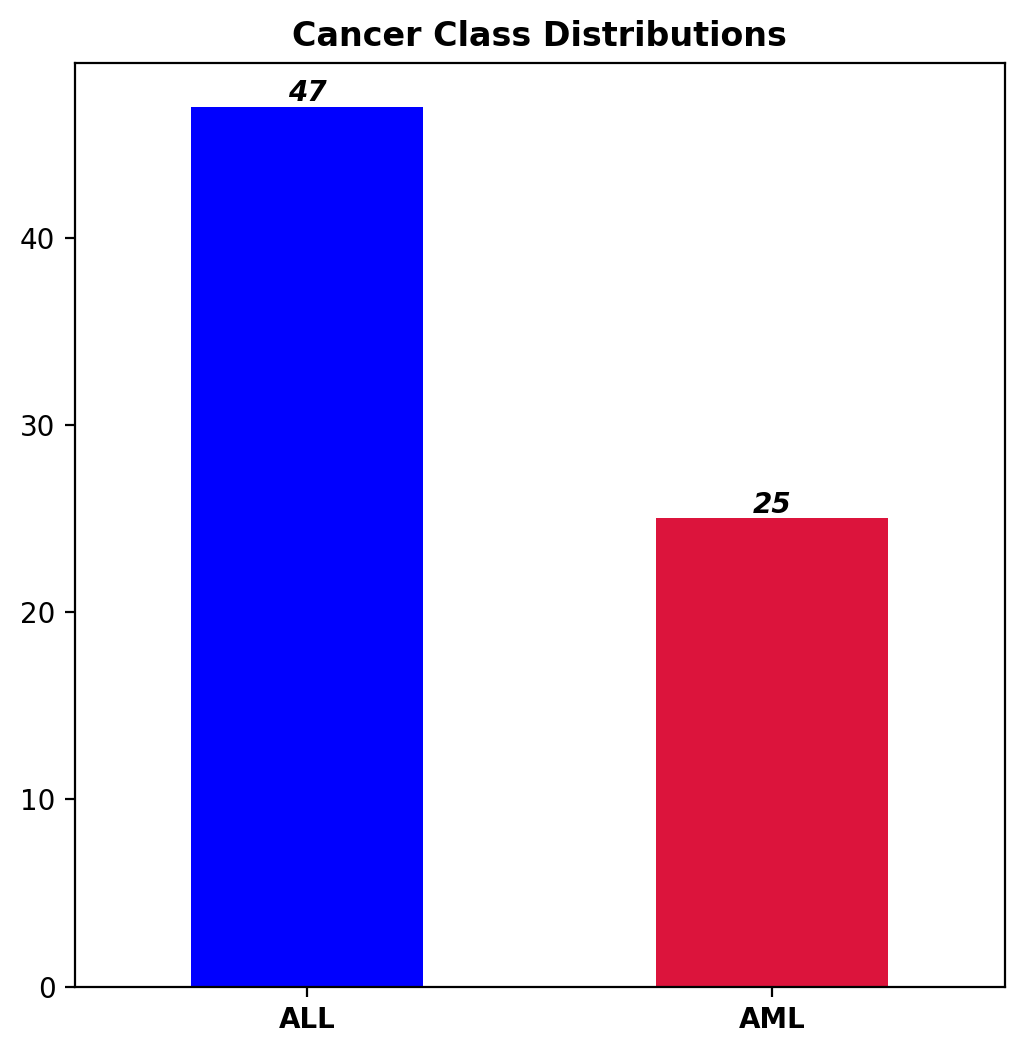

In [23]:
ax=data['cancer'].value_counts().plot(kind='bar',color=['blue','crimson'],figsize=(6,6))
plt.title('Cancer Class Distributions',weight='bold')
plt.xticks(rotation=0,weight='bold')
plt.bar_label(ax.containers[0],fontstyle='oblique',weight='bold')


In [129]:
X, y = data.drop(columns=["cancer",'Cancer','patient']), data["Cancer"]


In [130]:
X_train, X_test, y_train, y_test =  train_test_split(X,y,test_size = 0.25, random_state= 0)

Text(0.5, 1.0, 'Feature Kernel Density Estimate')

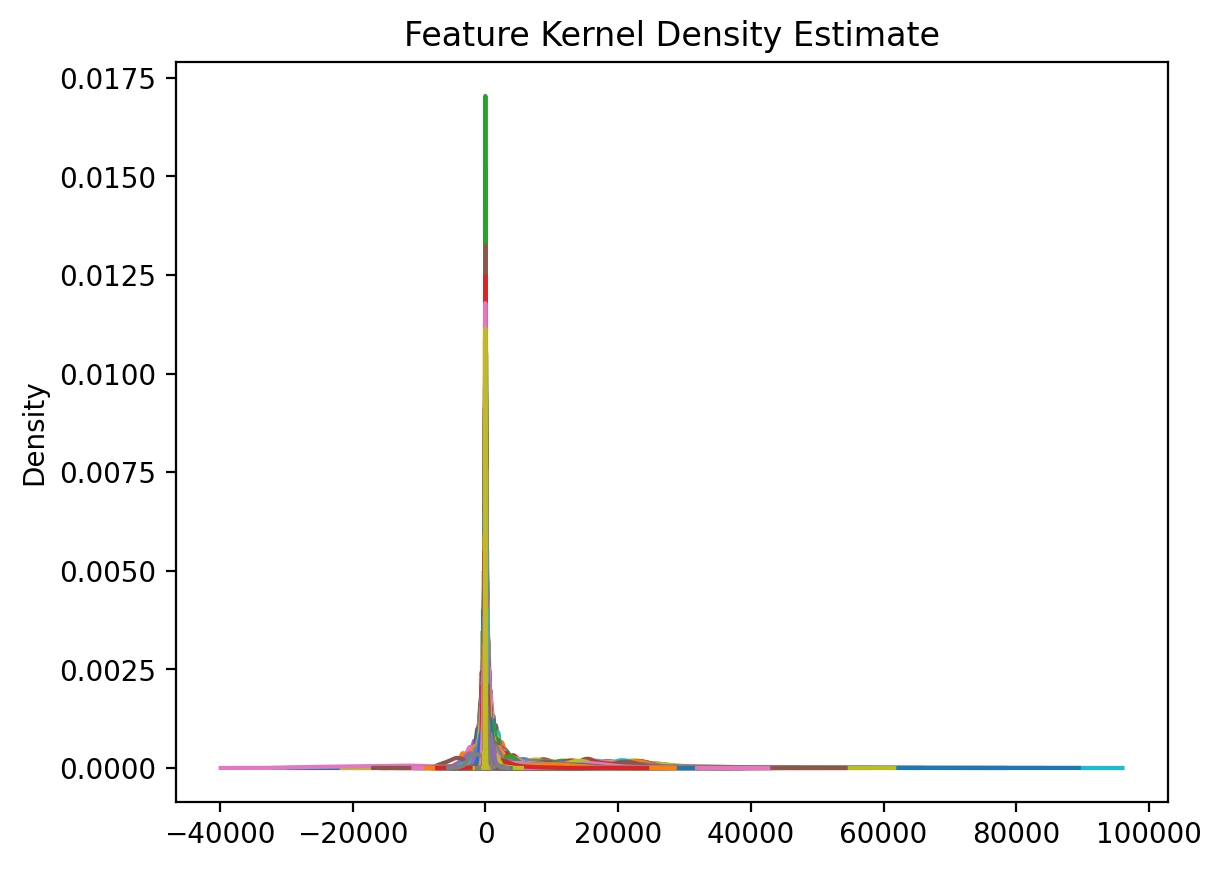

In [131]:
t=pd.DataFrame(X_train)
t.plot(kind="kde", legend=None)
plt.title('Feature Kernel Density Estimate')

In [132]:
#feature scaling
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

Text(0.5, 1.0, 'Normalized Feature Kernel Density Estimate')

<Figure size 1000x800 with 0 Axes>

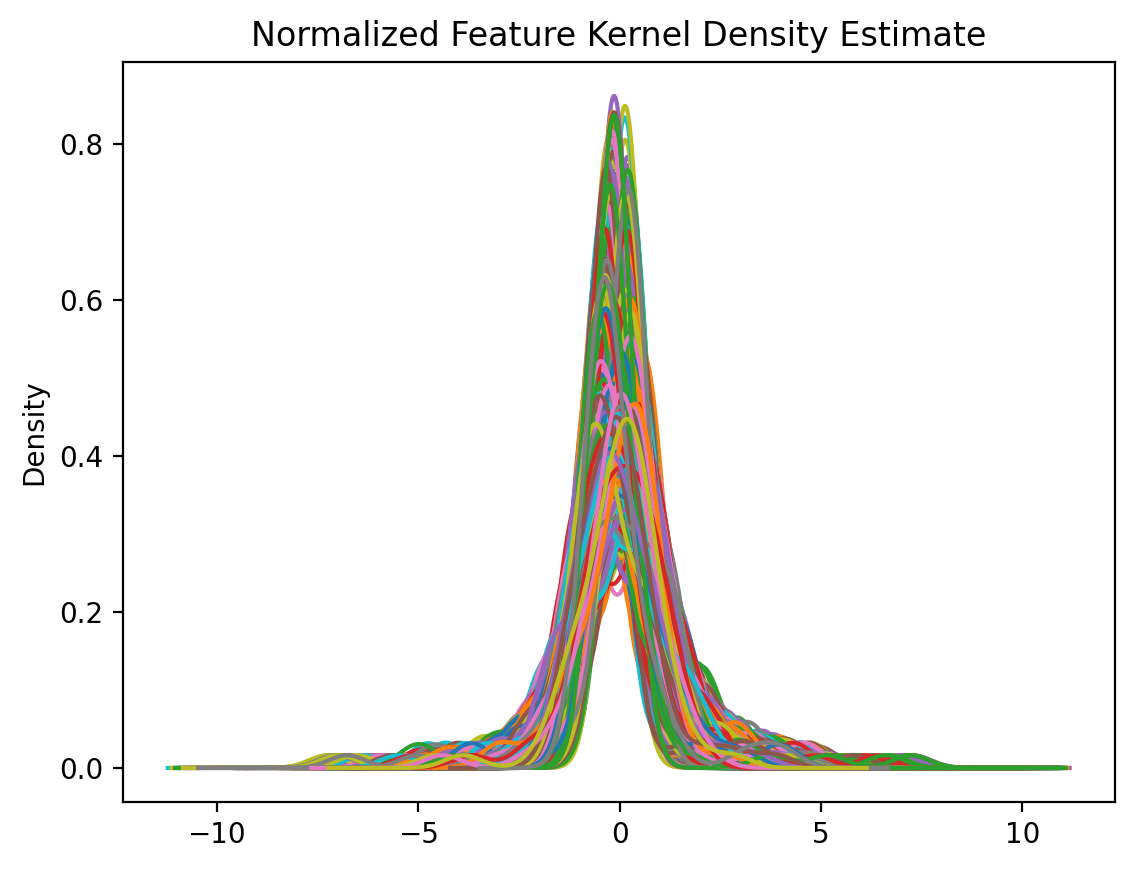

In [133]:
t=pd.DataFrame(X_train)
plt.figure(figsize=(10,8))
t.plot(kind="kde", legend=None)
plt.title('Normalized Feature Kernel Density Estimate')


39 features explain around 90% of the variance. Using PCA dimension reductionality we reduced 
our dataset from 7129 features to 39.


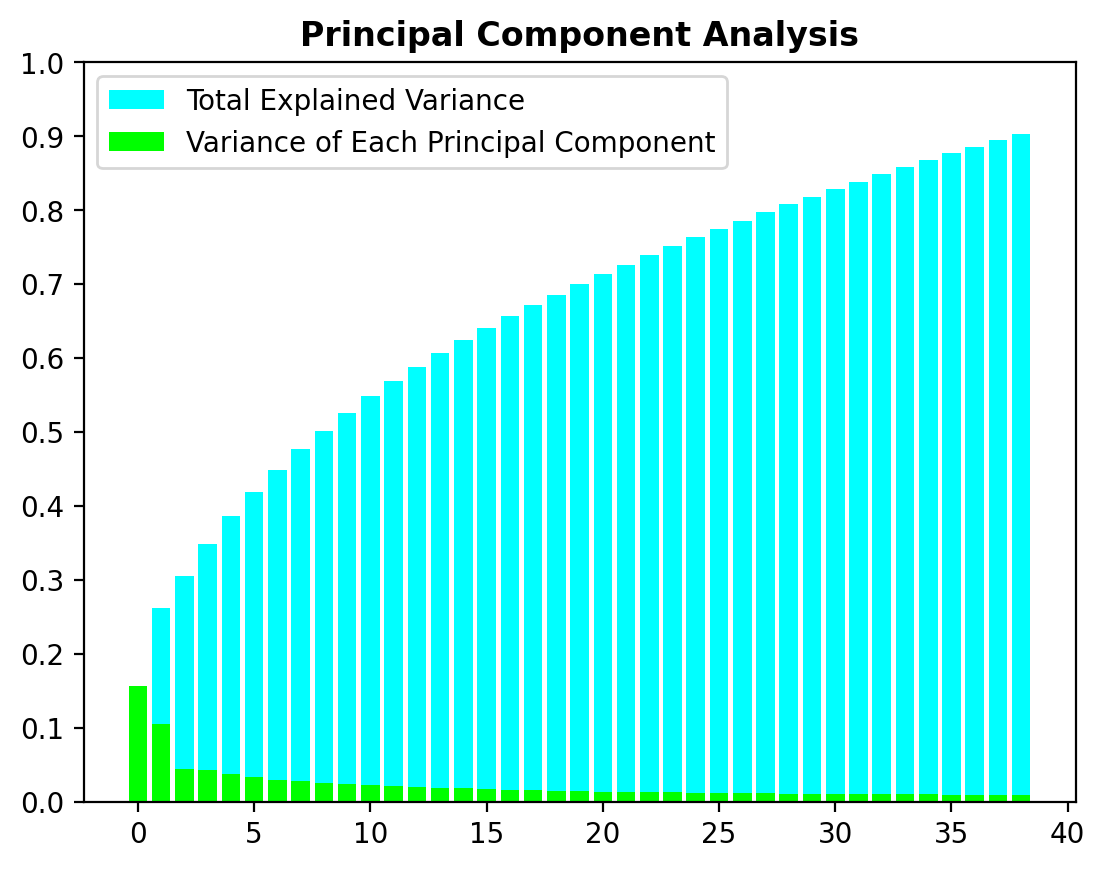

In [141]:
pca = PCA()
pca.fit_transform(X_train)
total = sum(pca.explained_variance_)

    


pca = PCA(n_components=k)
X_train_pca = pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)




ello=pca.explained_variance_ratio_
var_exp = pca.explained_variance_ratio_.cumsum()
var_exp = var_exp*1
ax=plt.bar(range(k), var_exp,color = 'aqua')
plt.bar(range(k),ello,color='lime')
plt.legend(['Total Explained Variance','Variance of Each Principal Component'])
plt.title('Principal Component Analysis',weight='bold')
plt.yticks([0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1])
print(k, " features explain around 90% of the variance. Using PCA dimension reductionality we reduced \nour dataset from 7129 features to ", k, ".", sep='')

In [135]:
len(pca.fit_transform(X_train)[0])

39

C:\Users\smore\AppData\Local\Temp\ipykernel_19440\2623209283.py:7: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig, elev=-150, azim=110,)


[Text(-40.0, 0, ''),
 Text(-30.0, 0, ''),
 Text(-20.0, 0, ''),
 Text(-10.0, 0, ''),
 Text(0.0, 0, ''),
 Text(10.0, 0, ''),
 Text(20.0, 0, ''),
 Text(30.0, 0, ''),
 Text(40.0, 0, ''),
 Text(50.0, 0, ''),
 Text(60.0, 0, '')]

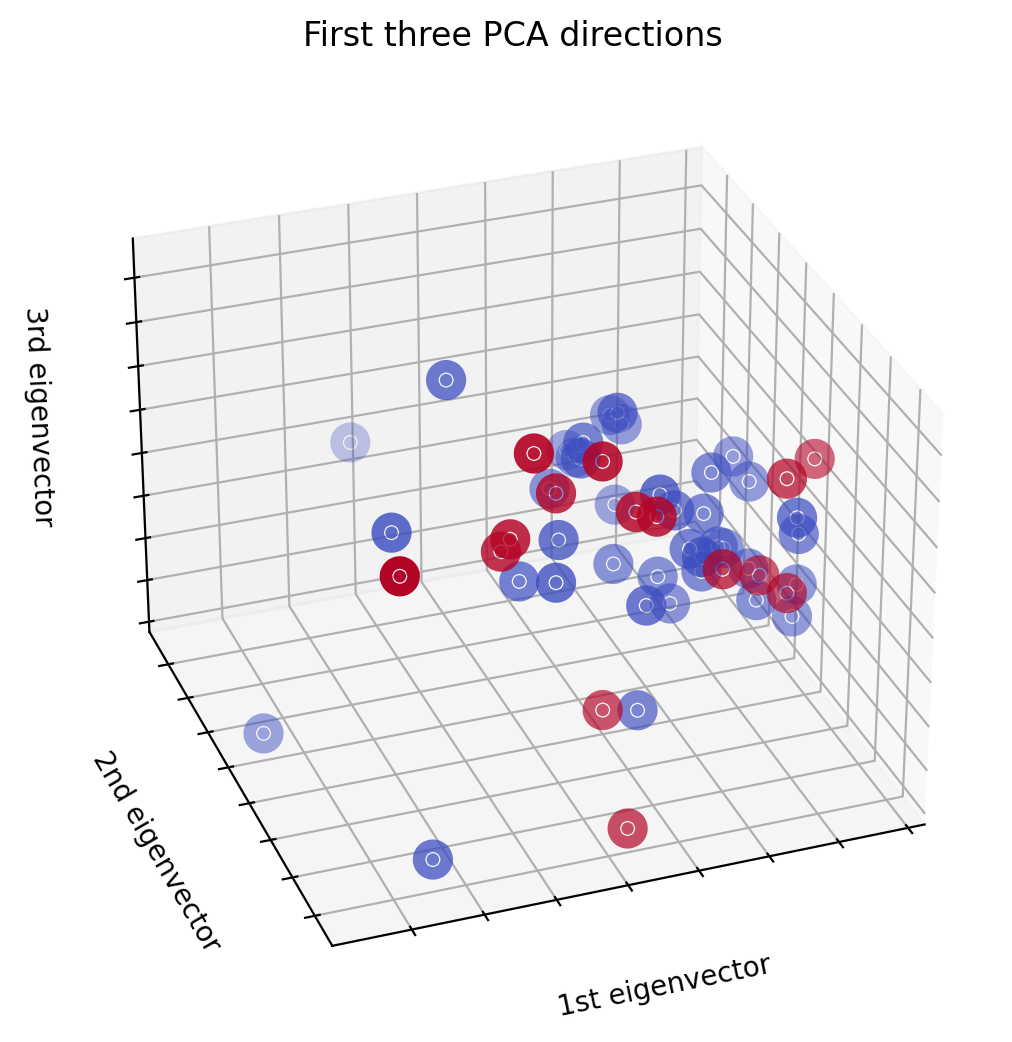

In [142]:
from mpl_toolkits.mplot3d import Axes3D

pca3 = PCA(n_components=3).fit(X_train)
X_train_reduced = pca3.transform(X_train)
plt.clf()
fig = plt.figure(1, figsize=(10,6))
ax = Axes3D(fig, elev=-150, azim=110,)
ax.scatter(X_train_reduced[:, 0], X_train_reduced[:, 1], X_train_reduced[:, 2], c = y_train, cmap='coolwarm', linewidths=10)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

The accuracy of SVM is 0.9444444444444444

Classification report :
               precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.90      0.95        10

    accuracy                           0.94        18
   macro avg       0.94      0.95      0.94        18
weighted avg       0.95      0.94      0.94        18



Text(0.5, 1.0, 'ROC - CURVE & AREA UNDER CURVE')

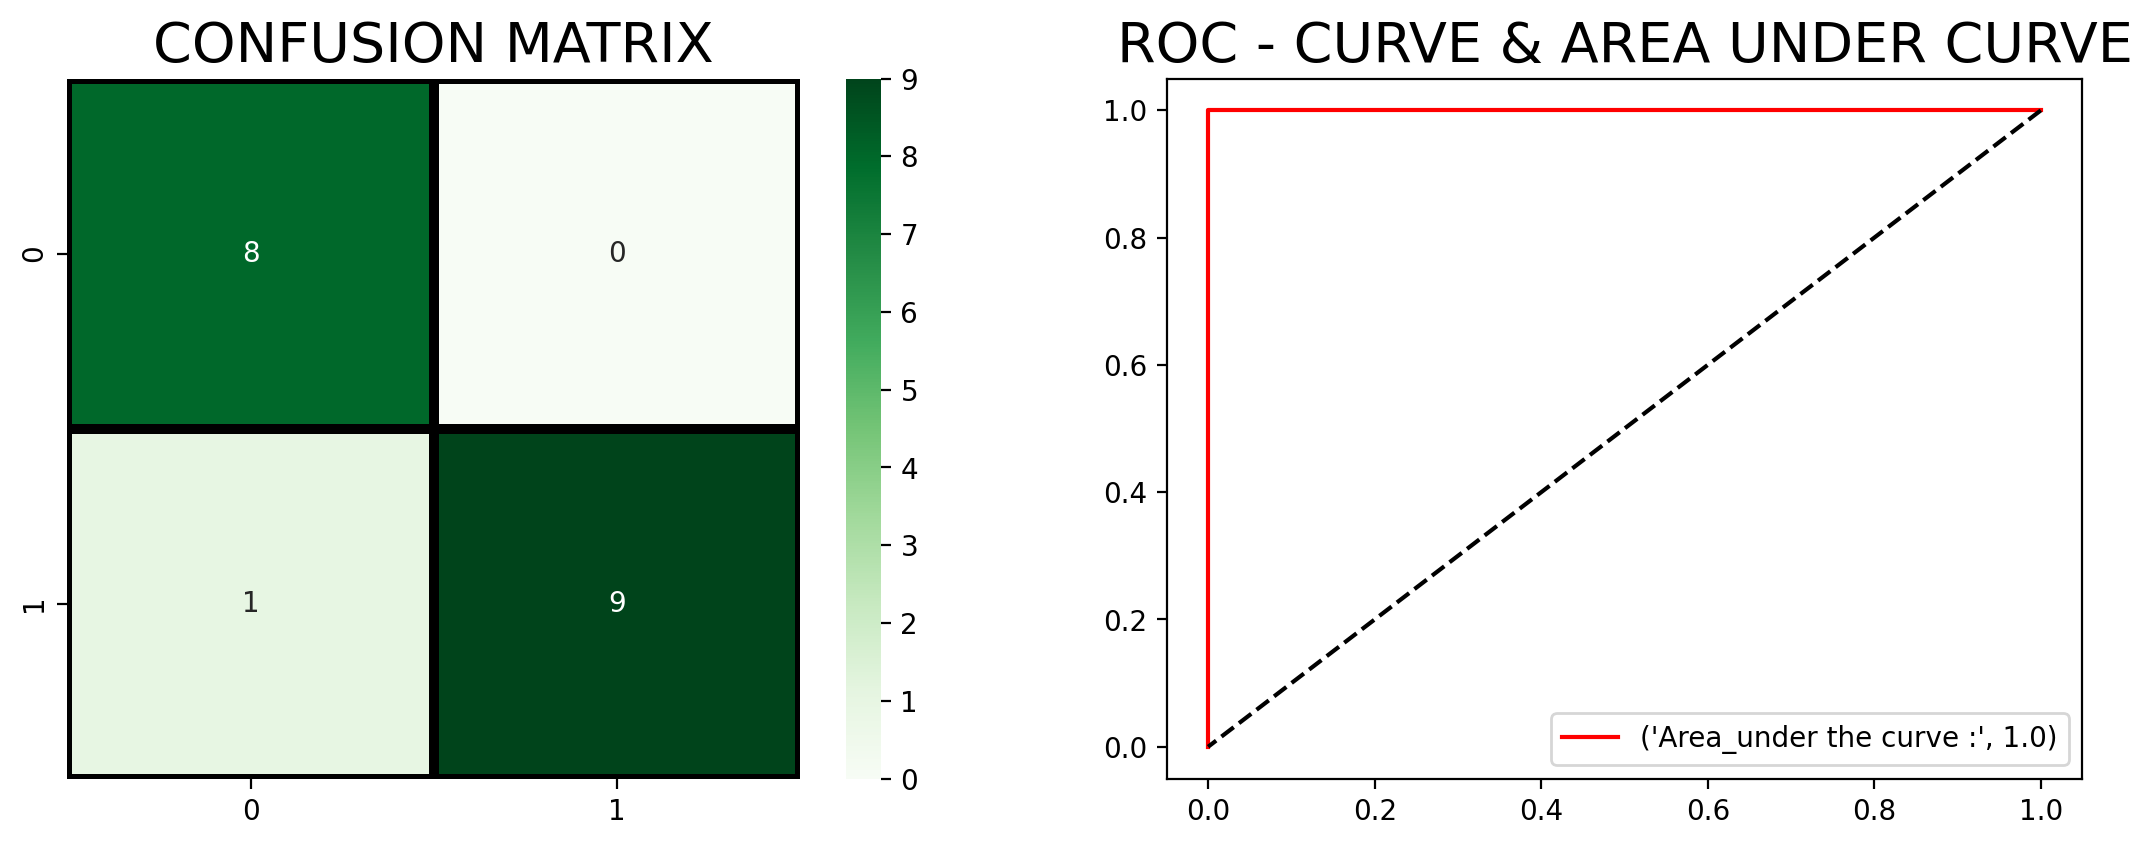

In [153]:
svc_model = SVC(C=1, kernel='linear',probability=True)

svc_model.fit(X_train_pca, y_train)

prediction=svc_model.predict(X_test_pca)

acc_svc = accuracy_score(prediction,y_test)

print('The accuracy of SVM is', acc_svc)
print ("\nClassification report :\n",(classification_report(y_test,prediction)))

#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,prediction),annot=True, cmap='Greens', fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

predicting_probabilites = svc_model.predict_proba(X_test_pca)[:,1]
fpr,tpr,thresholds = roc_curve(y_test,predicting_probabilites)
plt.subplot(222)
plt.plot(fpr,tpr,label = ("Area_under the curve :",auc(fpr,tpr)),color = "r")
plt.plot([1,0],[1,0],linestyle = "dashed",color ="k")
plt.legend(loc = "best")
plt.title("ROC - CURVE & AREA UNDER CURVE",fontsize=20)


The accuracy of K-NN is 0.5555555555555556

Classification report :
               precision    recall  f1-score   support

           0       0.50      1.00      0.67         8
           1       1.00      0.20      0.33        10

    accuracy                           0.56        18
   macro avg       0.75      0.60      0.50        18
weighted avg       0.78      0.56      0.48        18



Text(0.5, 1.0, 'ROC - CURVE & AREA UNDER CURVE')

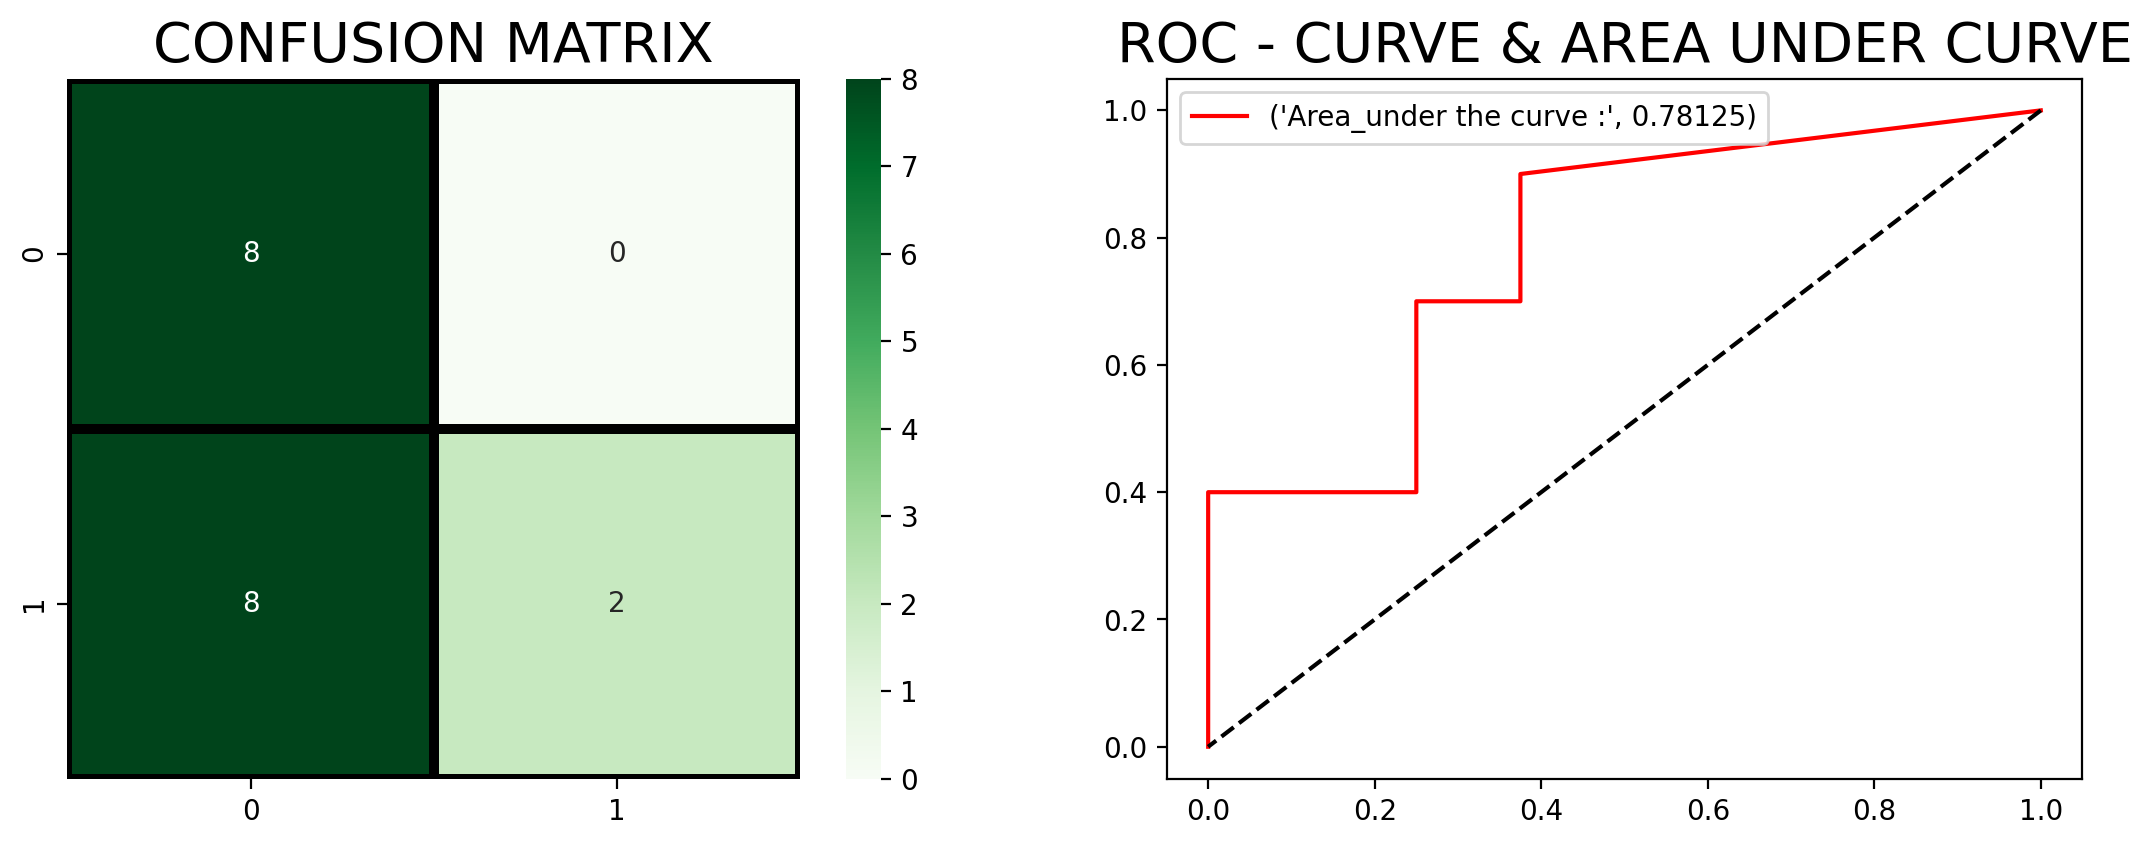

In [166]:
knn_model = KNeighborsClassifier( n_neighbors=5,
                     weights='distance')

knn_model.fit(X_train_pca,y_train)
prediction=knn_model.predict(X_test_pca)

acc_knn = accuracy_score(prediction,y_test)
print('The accuracy of K-NN is', acc_knn)
print ("\nClassification report :\n",(classification_report(y_test,prediction)))

#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,prediction),annot=True, cmap='Greens', fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

#ROC curve and Area under the curve plotting
predicting_probabilites = knn_model.predict_proba(X_test_pca)[:,1]
fpr,tpr,thresholds = roc_curve(y_test,predicting_probabilites)
plt.subplot(222)
plt.plot(fpr,tpr,label = ("Area_under the curve :",auc(fpr,tpr)),color = "r")
plt.plot([1,0],[1,0],linestyle = "dashed",color ="k")
plt.legend(loc = "best")
plt.title("ROC - CURVE & AREA UNDER CURVE",fontsize=20)

Validation accuracy of Logistic Regression is 0.9444444444444444

Classification report :
               precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.91      1.00      0.95        10

    accuracy                           0.94        18
   macro avg       0.95      0.94      0.94        18
weighted avg       0.95      0.94      0.94        18



Text(0.5, 1.0, 'ROC - CURVE & AREA UNDER CURVE')

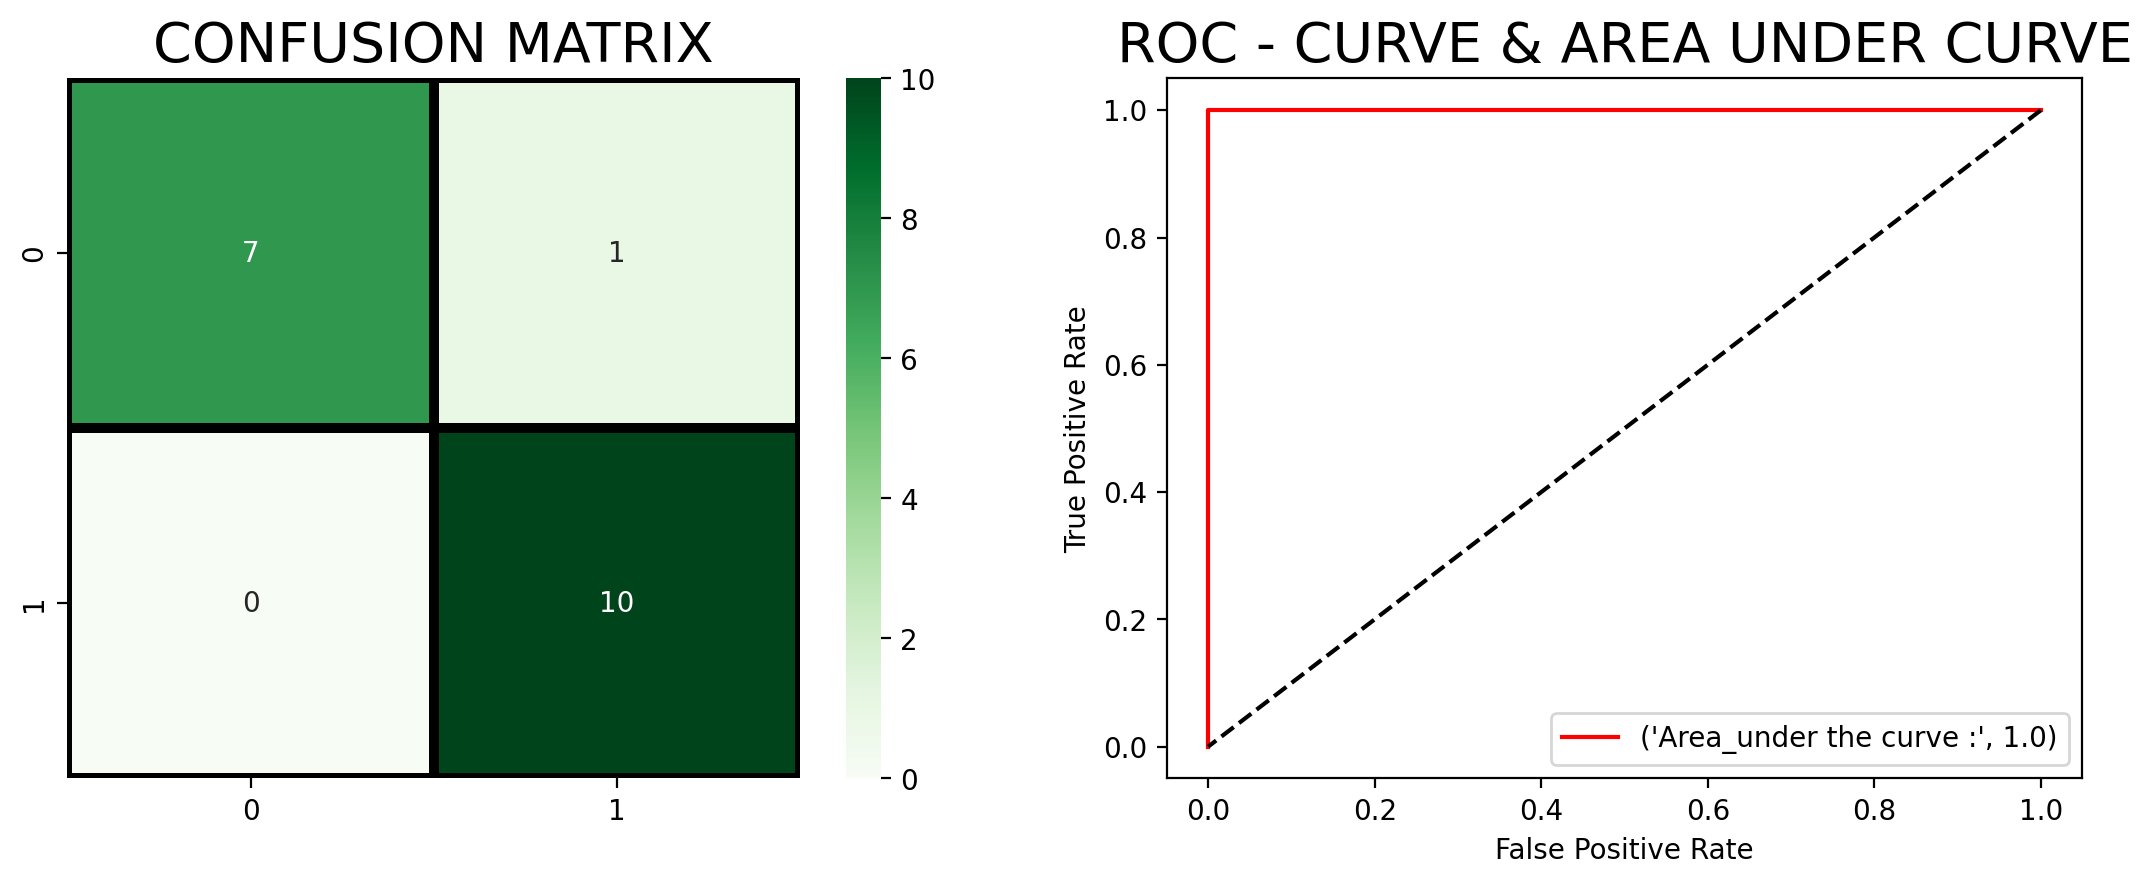

In [167]:
lr_model = LogisticRegression(C=0.001, solver='liblinear')

lr_model.fit(X_train_pca,y_train)

prediction=lr_model.predict(X_test_pca)

acc_log = accuracy_score(prediction,y_test)
print('Validation accuracy of Logistic Regression is', acc_log)
print ("\nClassification report :\n",(classification_report(y_test,prediction)))

#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,prediction),annot=True,cmap="Greens",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

#ROC curve and Area under the curve plotting
predicting_probabilites = lr_model.predict_proba(X_test_pca)[:,1]
fpr,tpr,thresholds = roc_curve(y_test,predicting_probabilites)
plt.subplot(222)
plt.plot(fpr,tpr,label = ("Area_under the curve :",auc(fpr,tpr)),color = "r")
plt.plot([1,0],[1,0],linestyle = "dashed",color ="k")
plt.legend(loc = "best")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC - CURVE & AREA UNDER CURVE",fontsize=20)

Validation accuracy of Decision Tree is 0.6111111111111112

Classification report :
               precision    recall  f1-score   support

           0       0.54      0.88      0.67         8
           1       0.80      0.40      0.53        10

    accuracy                           0.61        18
   macro avg       0.67      0.64      0.60        18
weighted avg       0.68      0.61      0.59        18



Text(0.5, 1.0, 'ROC - CURVE & AREA UNDER CURVE')

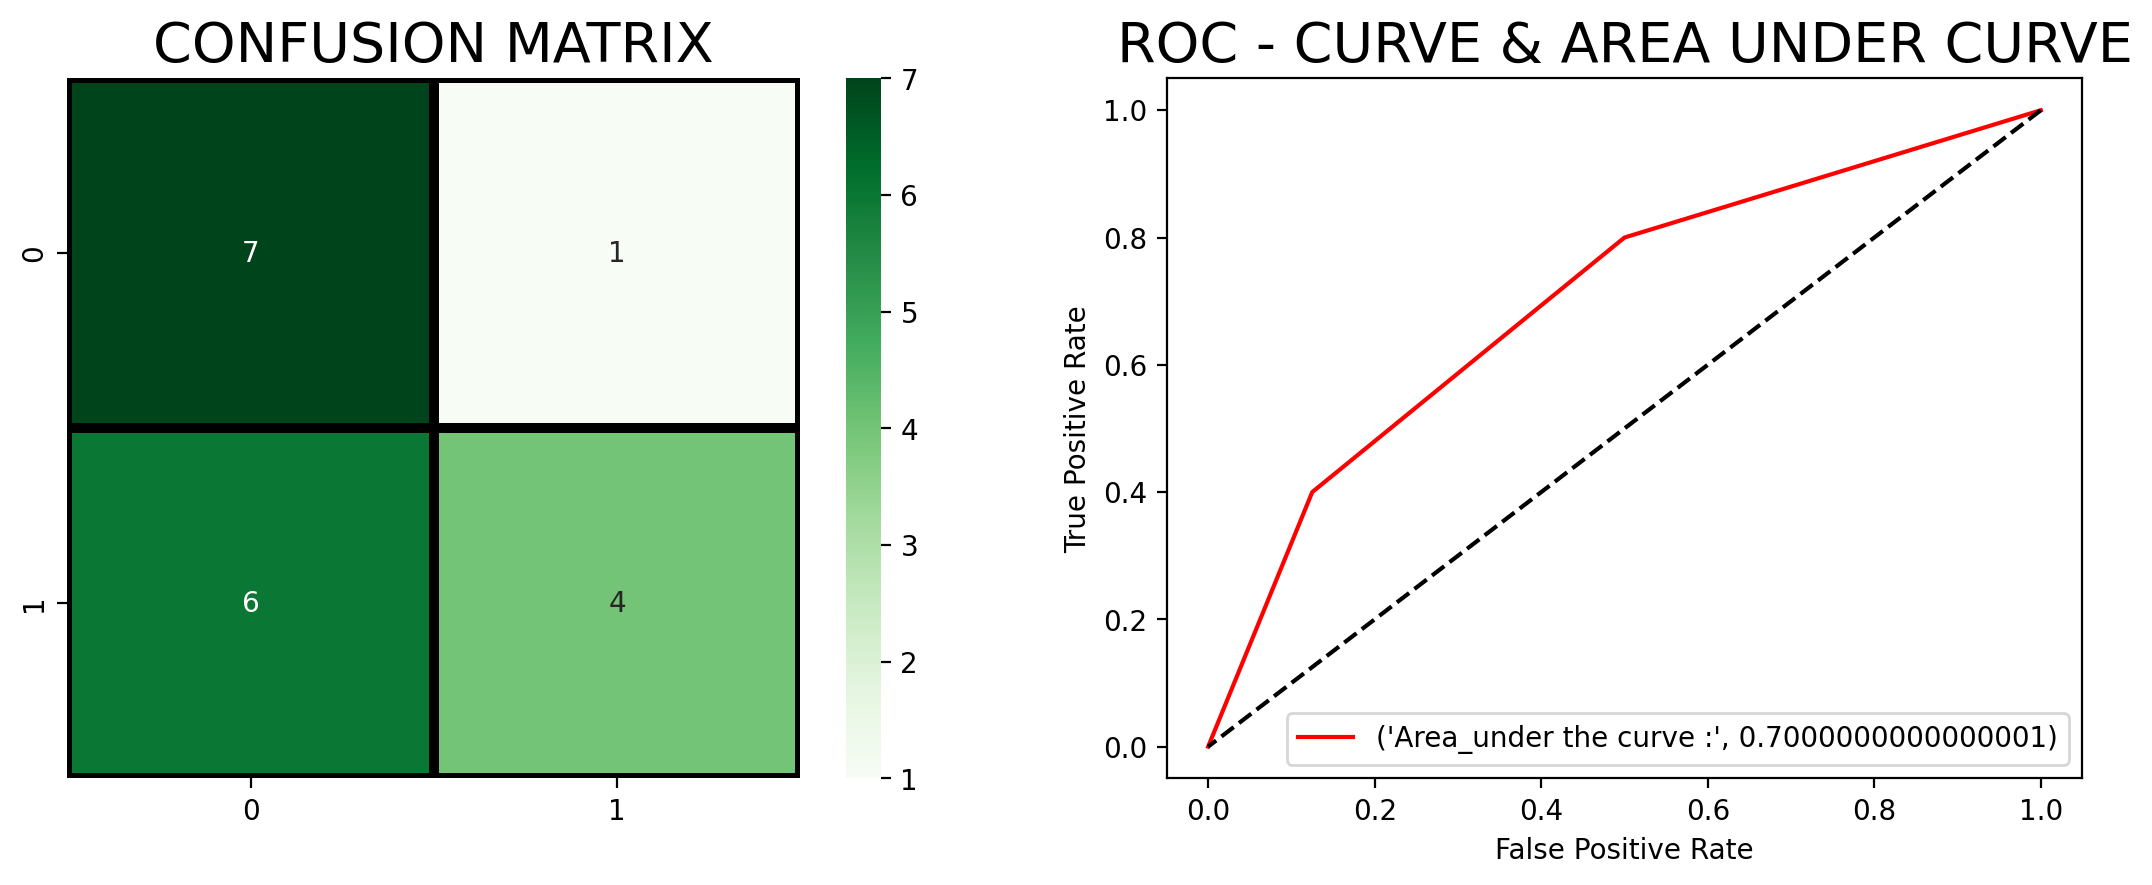

In [170]:
#Decision Tree
ds_model = DecisionTreeClassifier(max_depth=3, max_leaf_nodes=3, random_state=42)

ds_model.fit(X_train_pca,y_train)

prediction=ds_model.predict(X_test_pca)

acc_decision_tree = accuracy_score(prediction,y_test)
print('Validation accuracy of Decision Tree is', acc_decision_tree)
print ("\nClassification report :\n",(classification_report(y_test,prediction)))

#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,prediction),annot=True,cmap="Greens",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

#ROC curve and Area under the curve plotting
predicting_probabilites = ds_model.predict_proba(X_test_pca)[:,1]
fpr,tpr,thresholds = roc_curve(y_test,predicting_probabilites)
plt.subplot(222)
plt.plot(fpr,tpr,label = ("Area_under the curve :",auc(fpr,tpr)),color = "r")
plt.plot([1,0],[1,0],linestyle = "dashed",color ="k")
plt.legend(loc = "best")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC - CURVE & AREA UNDER CURVE",fontsize=20)

Validation accuracy of RandomForest Classifier is 0.5555555555555556

Classification report :
               precision    recall  f1-score   support

           0       0.50      0.88      0.64         8
           1       0.75      0.30      0.43        10

    accuracy                           0.56        18
   macro avg       0.62      0.59      0.53        18
weighted avg       0.64      0.56      0.52        18



Text(0.5, 1.0, 'ROC - CURVE & AREA UNDER CURVE')

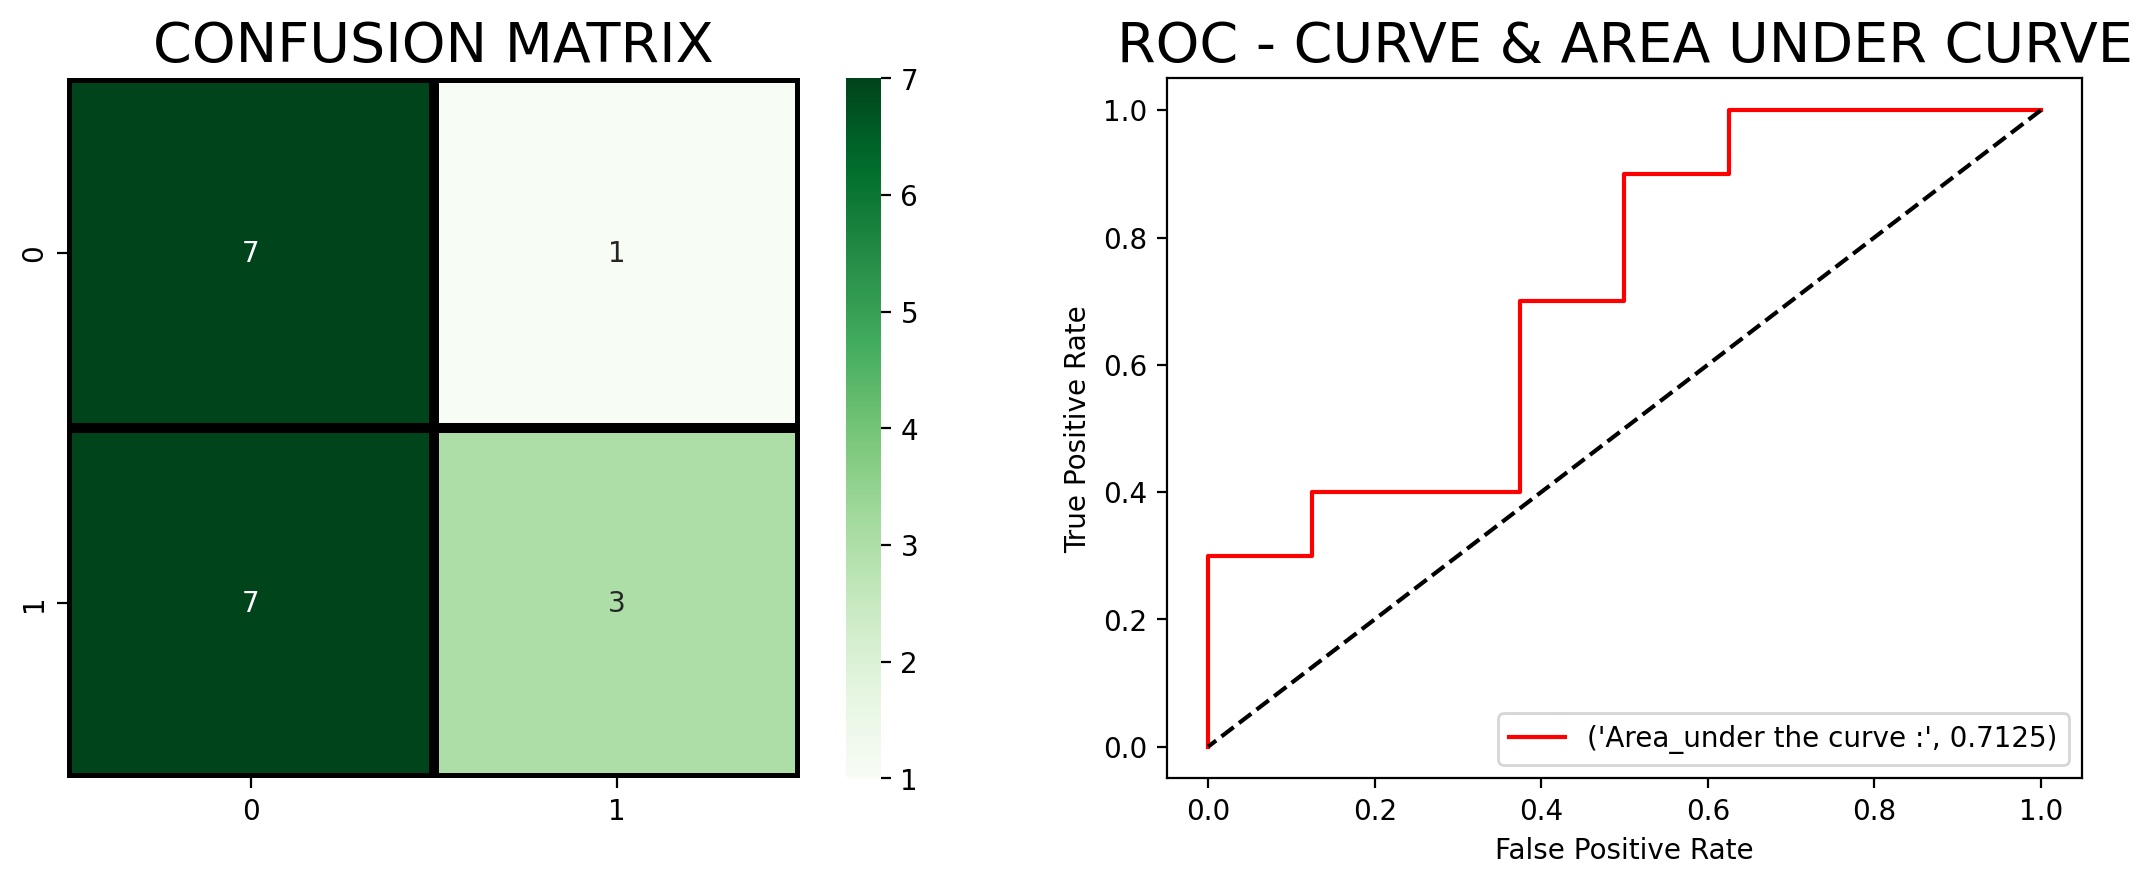

In [177]:
#Random forest
rf_model = RandomForestClassifier(bootstrap=False, max_features=0.6, min_samples_leaf=8,
                       min_samples_split=3, n_estimators=70)

rf_model.fit(X_train_pca,y_train)

prediction=rf_model.predict(X_test_pca)

acc_random_forest = accuracy_score(prediction,y_test)
print('Validation accuracy of RandomForest Classifier is', acc_random_forest)
print ("\nClassification report :\n",(classification_report(y_test,prediction)))

#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,prediction),annot=True,cmap="Greens",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

#ROC curve and Area under the curve plotting
predicting_probabilites = rf_model.predict_proba(X_test_pca)[:,1]
fpr,tpr,thresholds = roc_curve(y_test,predicting_probabilites)
plt.subplot(222)
plt.plot(fpr,tpr,label = ("Area_under the curve :",auc(fpr,tpr)),color = "r")
plt.plot([1,0],[1,0],linestyle = "dashed",color ="k")
plt.legend(loc = "best")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC - CURVE & AREA UNDER CURVE",fontsize=20)

Validation accuracy of XG Boost is 0.6111111111111112

Classification report :
               precision    recall  f1-score   support

           0       0.54      0.88      0.67         8
           1       0.80      0.40      0.53        10

    accuracy                           0.61        18
   macro avg       0.67      0.64      0.60        18
weighted avg       0.68      0.61      0.59        18



Text(0.5, 1.0, 'ROC - CURVE & AREA UNDER CURVE')

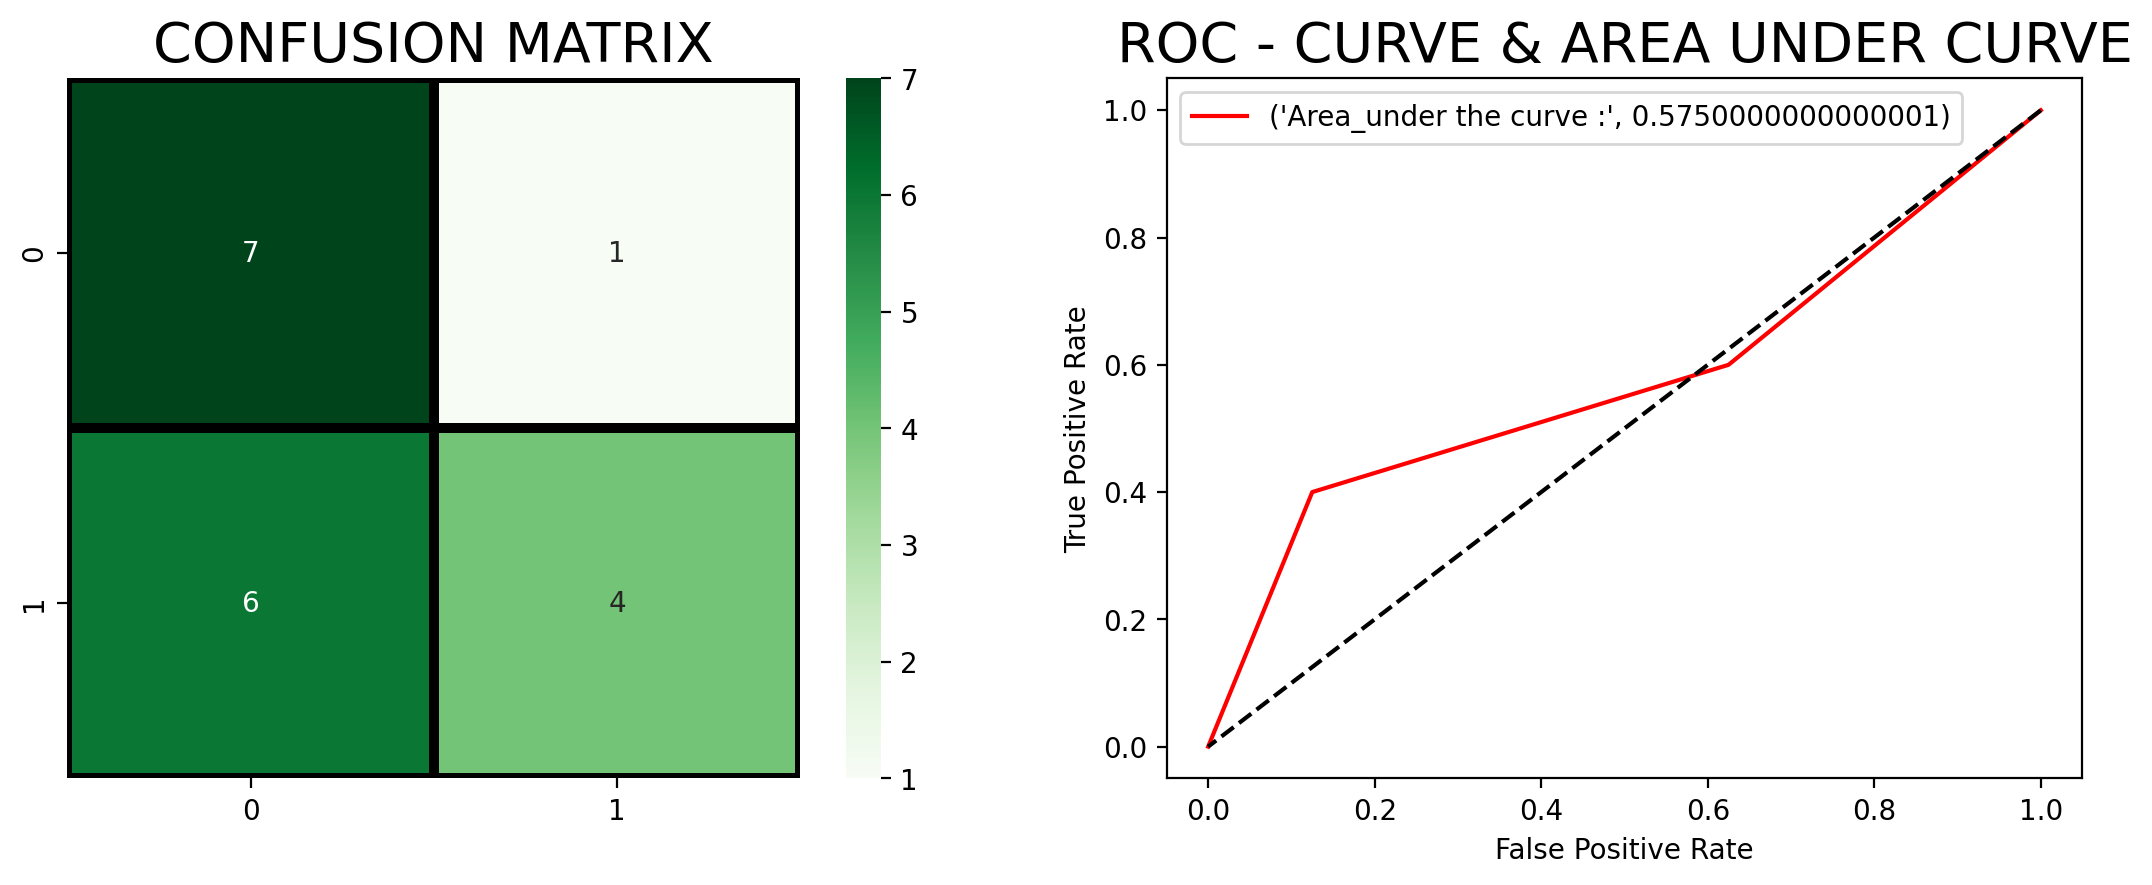

In [181]:
#XB Boost
xgb_model = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.001, max_delta_step=0, max_depth=3,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=40, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

xgb_model.fit(X_train_pca,y_train)

prediction=xgb_model.predict(X_test_pca)

acc_xgb = accuracy_score(prediction,y_test)
print('Validation accuracy of XG Boost is', acc_xgb)
print ("\nClassification report :\n",(classification_report(y_test,prediction)))

#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,prediction),annot=True,cmap="Greens",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

#ROC curve and Area under the curve plotting
predicting_probabilites = xgb_model.predict_proba(X_test_pca)[:,1]
fpr,tpr,thresholds = roc_curve(y_test,predicting_probabilites)
plt.subplot(222)
plt.plot(fpr,tpr,label = ("Area_under the curve :",auc(fpr,tpr)),color = "r")
plt.plot([1,0],[1,0],linestyle = "dashed",color ="k")
plt.legend(loc = "best")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC - CURVE & AREA UNDER CURVE",fontsize=20)

Validation accuracy of Naive Bayes is 0.4444444444444444

Classification report :
               precision    recall  f1-score   support

           0       0.44      1.00      0.62         8
           1       0.00      0.00      0.00        10

    accuracy                           0.44        18
   macro avg       0.22      0.50      0.31        18
weighted avg       0.20      0.44      0.27        18



C:\Users\smore\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\smore\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\smore\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 1.0, 'ROC - CURVE & AREA UNDER CURVE')

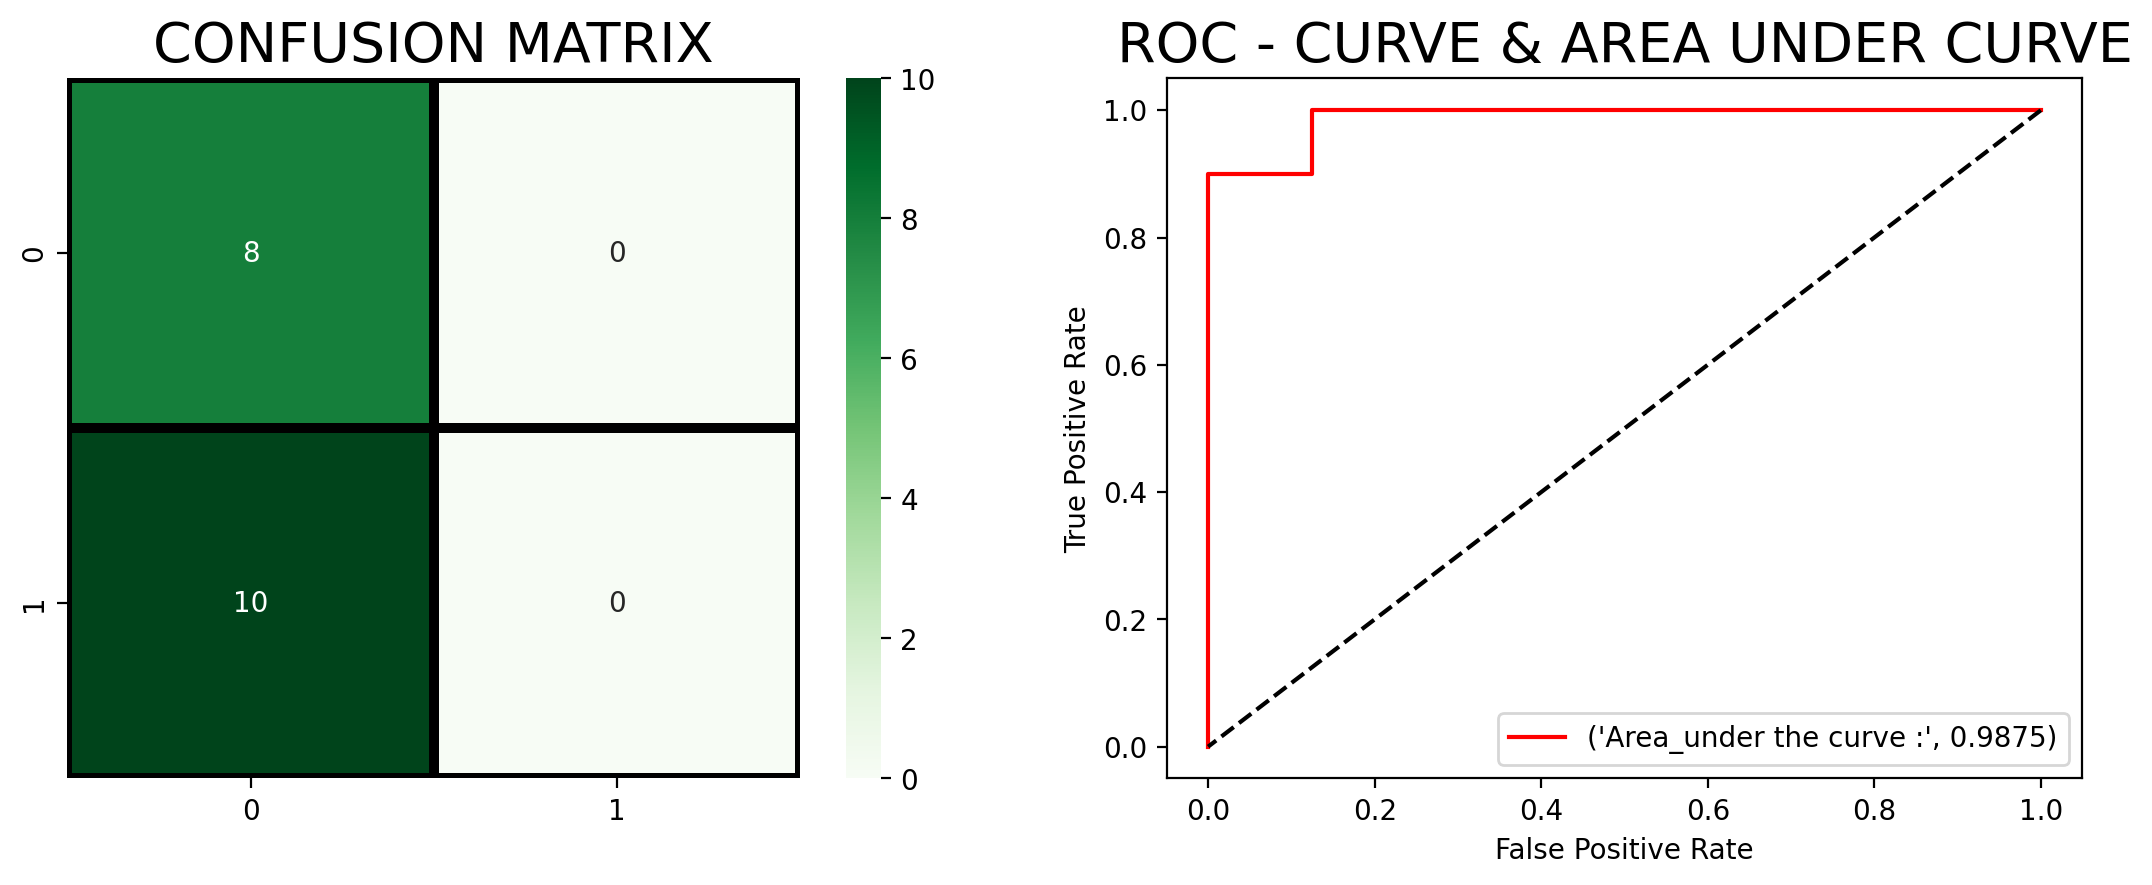

In [184]:
from sklearn.naive_bayes import GaussianNB
#In case of naive Bayes, there isn't a hyper-parameter to tune, so you have nothing to grid search over.
nb_model = GaussianNB()

nb_model.fit(X_train_pca,y_train)

prediction=nb_model.predict(X_test_pca)

acc_nb = accuracy_score(prediction,y_test)
print('Validation accuracy of Naive Bayes is', acc_nb)
print ("\nClassification report :\n",(classification_report(y_test,prediction)))

#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,prediction),annot=True,cmap="Greens",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

#ROC curve and Area under the curve plotting
predicting_probabilites = nb_model.predict_proba(X_test_pca)[:,1]
fpr,tpr,thresholds = roc_curve(y_test,predicting_probabilites)
plt.subplot(222)
plt.plot(fpr,tpr,label = ("Area_under the curve :",auc(fpr,tpr)),color = "r")
plt.plot([1,0],[1,0],linestyle = "dashed",color ="k")
plt.legend(loc = "best")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC - CURVE & AREA UNDER CURVE",fontsize=20)

In [185]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 'Decision Tree',
              'Random Forest', 'XG Boost', 'Naive Bayes'],

    'Score': [acc_svc, acc_knn, acc_log, acc_decision_tree, 
              acc_random_forest, acc_xgb, acc_nb]})
models.sort_values(by='Score', ascending=False)

,Model,Score
0,Support Vector Machines,0.944444
2,Logistic Regression,0.944444
3,Decision Tree,0.611111
5,XG Boost,0.611111
1,KNN,0.555556
4,Random Forest,0.555556
6,Naive Bayes,0.444444
